# Geodatenanalyse 2 - Termin Machine Learning 3 (ANN, MLP)
## ANN - Multilayer Perceptron
### Import von benötigten Paketen


**Die folgenden beiden Zellen werden aufgrund eines Bugs in der aktuellen Scikit-Version benötigt. Diese bitte genau einmal ausführen, danach den Kernel neu starten. Es muss sklearn Version 1.3.2 installiert sein!**

In [9]:
#!pip install scikit-learn==1.3.2

In [18]:
import sklearn
import scikeras
print("sklearn:", sklearn.__version__)
print("scikeras:", scikeras.__version__)

sklearn: 1.3.2
scikeras: 0.13.0


In [19]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Pre-processing
Wir verwenden für diesen Teil wieder die Grundwasserqualitätsdaten, die wir bereits beim vorigen Termin für die Binär-Klassifikation verwendet haben. Ziel ist es, mit Hilfe der anderen Parameter jeweils die Landnutzung (d.h. landwirtschaftlich ja/nein) in Form einer Binär-Klassifikation sowie die Nitrat-Gehalte in Form einer Regression vorherzusagen.

Die Daten sind bereits teilweise pre-processed (kategorische Variablen sind encodiert, Werte unter der NWG wurden ersetzt). Wir prüfen nun noch, ob Nan-Werte vorhanden sind, löschen diesen, und löschen anschließend noch nicht benötigte Spalten.

In [20]:
# Einladen der Daten
filename = 'gwdata_2005.csv'
dataset = pd.read_csv(filename, delimiter=';', encoding='latin1')

# Prüfen auf Nan-Werte
dataset.isnull().sum()


GWNum           0
Messstelle      0
Ca              0
Cl              0
DOC             0
LF_mS_m         0
K               0
Mg              0
Na              0
NO3             0
pH             50
SO4             0
SiO2            0
U               0
PSM             0
Rechtswert      0
Hochwert        0
Aquifer_kz      0
Aquifer         6
Aquifer2        0
landuse         0
landuse_num     0
dtype: int64

In [21]:
# Löschen von Zeilen mit Nan-Werten und nicht benötigter Spalten

dataset_cleaned = dataset.dropna()

mydata = dataset_cleaned.drop(['GWNum','Messstelle','Rechtswert', 'Hochwert', 'Aquifer','Aquifer2','landuse'], axis=1)
mydata.head()

,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,NO3,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,12.4,6.92,15.6,8.9,0.00025,0.0,31,0
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,4.5,6.78,2.0,10.7,0.00025,0.0,81,0
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,4.0,6.69,4.0,16.0,0.00025,0.0,91,0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.4,6.96,3.4,18.6,0.00025,0.0,91,0
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,18.2,7.25,23.1,12.3,0.00025,0.0,4,0


## Klassifikation
### Splitten der Daten

Das Aufteilen des Datensatzes erfolgt mit der Funktion ["train_test_split"](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split) des Packages sklearn.

Hier kann mit dem Parameter "test_size" das Verhältnis festgelegt werden und mit dem Parameter "random_state" die Reproduzierbarkeit garantiert werden. Der Testdatensatz dient später dazu, zu evaluieren, wie gut das trainierte neuronale Netz generalisieren kann, d.h. Daten vorhersagen, die es vorher "noch nie gesehen hat".

Um Overfitting zu vermeiden und/oder das ANN hinsichtlich sog. Hyperparameter zu optimieren müssen wir die vorhandenen Daten weiter in einzelne Datensätze aufteilen. Je nach Zusammenhang bzw. Verwendung werden diese als Stopp-Set, Optimierungs-Set oder als Validation-Set bezeichnet. Diese können ebenfalls mit der Funktion train_test_split erzeugt werden.

Für den Anfang wollen wir lediglich einen weiteren Datensatz, um Overfitting zu vermeiden. Diesen bezeichnen wir mit val für validation. Er wird später bei jedem Trainingsschritt parallel beobachtet. Das ursprüngliche Training-Set (zunächst als temp bezeichnet) teilen wir dazu erneut auf:

In [22]:
from numpy.random import seed
seed(1)
# Falls Tensorflow noch nicht installiert ist, einmalig die nächste Zeile ausführen
#!pip install tensorflow
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

temp, test = train_test_split(mydata, test_size=0.2, random_state=27)

train, val = train_test_split(temp, test_size=0.1, random_state=27)

print('Größe Trainings-Set: ', train.shape)
print('Größe Validation-Set: ', val.shape)
print('Größe Test-Set: ', test.shape)

Größe Trainings-Set:  (1352, 15)
Größe Validation-Set:  (151, 15)
Größe Test-Set:  (376, 15)


### Skalieren

Für neuronale Netze müssen die Eingangsdaten skaliert werden. Je nach Datensatz und Fragestellung kann man die Daten entweder Normieren oder Standardisieren. Wir wählen hier die Normierung, damit unsere landuse_num Kategorien erhalten bleiben.

Der Scaler wird zunächst an die Daten des Trainings-Set gefittet. Anschließend werden sowohl Trainings-Set,  Validation-Set und Test-Set transformiert.

In [23]:
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### Aufteilen der Daten in Input- und Zieldaten

In [24]:
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_val = val[:, :-1] # for all but last column --> Input variables
y_val = val[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable


### Aufbau und Training des ANN

Wir importieren zunächst weitere nötige Pakete, und lesen dann die Anzahl der Input-features aus. Anschließend erstellen wir ein einfaches ANN mit einer Eingabeschicht (deren Neuronen-Zahl automatisch auf Basis der Anzahl der Input-Features erzeugt wird), einer verdeckten Schicht mit 5 Neuronen und einer Ausgabeschicht mit einem Neuron für unseren Zielwert (Landnutzung). Vollständig miteinerander verbundene Schichten (fully connected layers) werden in Keras als Dense-Layer bezeichnet. MLPs fallen unter die Kategorie der sog. sequentiellen Modelle (in denen die Schichten quasi nacheinander abgearbeitet werden). Näheres zur Erstellung sequentieller Modelle in Tensorflow-Keras findet sich [hier](https://www.tensorflow.org/guide/keras/sequential_model).

Weitere Hyperparameter des Modells (neben der Anzahl der Schichten und Neuronen) sind die [Initialisierungsfunktion](https://www.tensorflow.org/api_docs/python/tf/keras/initializers), die [Aktivierungsfunktion](https://www.tensorflow.org/api_docs/python/tf/keras/activations), der [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) und die [Batch-Size](https://www.tensorflow.org/guide/keras/training_with_built_in_methods) (Anzahl der Inputs, die dem Netz pro Epoche auf einmal präsentiert werden). Die Batch-Size wird während des Trainings mit der Funktion model.fit als Parameter angegeben, die Initialisierungs- und Aktivierungsfunktionen bei der Modell-Definition für jede Schicht, und der Optimizer als Parameter beim Kompilieren des Modells mit der Funktion model.compile.

Die Hyperparamter werden zunächst relativ wahllos gewählt. Als Aktivierungsfunktion verwenden wir "ReLu" für die verdeckte Schicht, was für die meisten Problem in der Regel gut funktioniert. Für die Ausgabeschicht verwenden wir eine sigmoidale Aktivierungsfunktion, um sicherzustellen, dass die Ausgabe des Netzwerks zwischen 0 und 1 liegt und sich leicht auf eine der beiden Klassen mit einem Standard-Schwellenwert von 0.5 abbilden lässt. Der Adam-Optimizer gilt ebenfalls für viele Probleme als Methode der Wahl. Bei der Batch-Size findet man häufig Anfangswerte von 16, 32 oder 64. Alle Hyperparameter können später noch optimiert werden. Als loss-Funktion kommt für die binäre Klassifikation "binary_crossentropy" zum Einsatz, als Metrik die "accuracy". Zunächst starten wir mit 50 Epochen.

Nach dem eigentlichen Training (model.fit) führen wir mit model.evaluate eine Vorhersage mit den validation-Inputs aus, um einen Hinweis dafür zu bekommen, wie gut das Modell ist.

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5870 - loss: 0.6824 - val_accuracy: 0.6755 - val_loss: 0.6575
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.6668 - val_accuracy: 0.6755 - val_loss: 0.6428
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.6586 - val_accuracy: 0.6755 - val_loss: 0.6360
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.6546 - val_accuracy: 0.6755 - val_loss: 0.6333
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.6511 - val_accuracy: 0.6821 - val_loss: 0.6312
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6141 - loss: 0.6477 - val_accuracy: 0.6887 - val_loss: 0.6281
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.6448 - val_accuracy: 0.6887 - val_loss: 0.6258
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.6422 - val_accuracy: 0.6954 - val_loss:

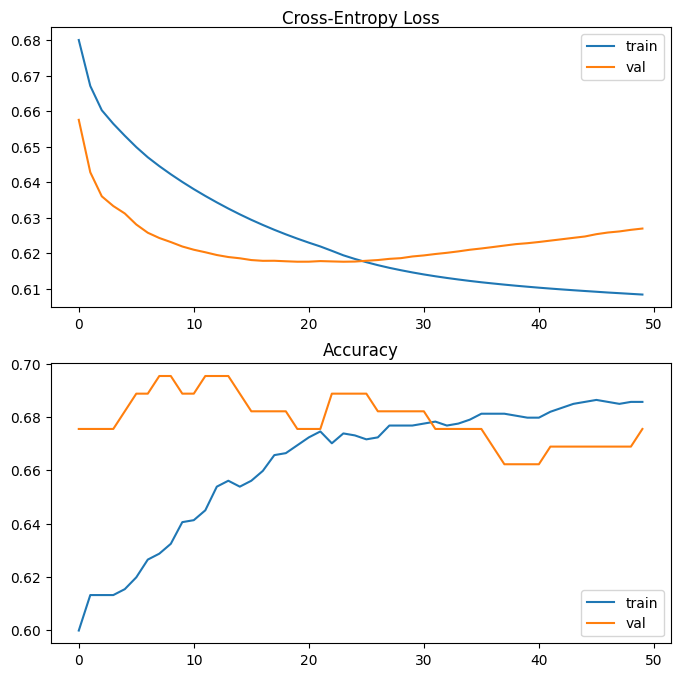

In [25]:
# import packages
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from matplotlib import pyplot

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model to training data, set number of epochs and batch_size
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_val,y_val))

# make class predictions with the model
predictions = (model.predict(X_val) > 0.5).astype("int32")

# compute accuracy
_, accuracy = model.evaluate(X_val,y_val)
print('Accuracy: %.2f' % (accuracy*100))

# plot loss learning curves

pyplot.figure(figsize=(8,8)) 
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

Falls wir sehen, dass ein Overfitting eintritt, können wir die Anzahl der Epochen von Hand anpassen und einen zweiten Durchlauf starten (später mehr zu Techniken, wie man das Training im Fall von Overfitting automatisch stoppen kann).

Die Accuracy liegt bei diesem sehr einfachen und nicht optimierten Modell für die Validierungsdaten immerhin schon bei knapp 70% und ist damit in etwa vergleichbar mit der Performance der einfacheren ML-Modelle beim vorigen Termin. Da diese Konfiguration ganz gut zu funktionieren scheint, bauen wir das Modell nochmals neu auf, trainieren es mit dem kompletten Trainingsdatensatz (inklusive der Validierungs-Daten) und sagen damit die Landnutzung unseres Test-Datensatzes voraus. Da im vorigen Versuch ein Overfitting bei etwa 20 Epochen eintrat, wählen wir statt 50 Epochen nun 20. **ACHTUNG: Die absoluten Werte für die Accuracy und die Anzahl der Epochen, bei denen Overfitting auftritt, variieren! Dies hängt vom Split der Daten und der Initialisierung ab!**

In [26]:
seed(1)
tf.random.set_seed(2)

# Split data
train, test = train_test_split(mydata, test_size=0.2, random_state=27)

# Scale data
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

# Input- and Target-Data
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable


# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()


# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# make class predictions with the model
predictions = model.predict(X_val)

# compute accuracy
_, accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6179 - loss: 0.6725
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.6172 - loss: 0.6684
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.6172 - loss: 0.6664
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.6179 - loss: 0.6648
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.6189 - loss: 0.6632
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.6189 - loss: 0.6616
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.6188 - loss: 0.6600
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.6211 - loss: 0.6583
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.6217 - loss: 0.6566
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.6200 - loss: 0.6548
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.6224 - loss: 0.6530
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step

Auch dies scheint offensichtlich ähnlich gut zu funktionieren, die Vorhersage-Genauigkeit für den Test-Datensatz ist in diesem Durchlauf nur etwa etwas geringer. Die eigentlichen Daten können je nach Durchlauf aufgrund der unterschiedlichen Initialisierungen variieren. Wie man das Modell robuster macht, dazu bei der Regression mehr.

## Regression

### Splitten der Daten

Zunächst sortieren wir für die Regression nun die Spalten so um, dass die Spalte mit den Werten, die wir später vorhersagen wollen, in diesem Fall Nitrat, am Ende steht. Das macht uns die Aufteilung in Input- und Zieldaten leichter. Anschließend wiederholen wir die Skalierung und Aufteilung der Daten.

Das Aufteilen des Datensatzes erfolgt mit der Funktion "train_test_split" des Packages sklearn.

Hier kann mit dem Parameter "test_size" das Verhältnis festgelegt werden und mit dem Parameter "random_state" die Reproduzierbarkeit garantiert werden. Der Testdatensatz dient später dazu, zu evaluieren, wie gut das trainierte neuronale Netz generalisieren kann, d.h. Daten vorhersagen, die es vorher "noch nie gesehen hat".

Um Overfitting zu vermeiden und/oder das ANN hinsichtlich sog. Hyperparameter zu optimieren müssen wir die vorhandenen Daten weiter in einzelne Datensätze aufteilen. Je nach Zusammenhang bzw. Verwendung werden diese als Stopp-Set, Optimierungs-Set oder als Validation-Set bezeichnet. Diese können ebenfalls mit der Funktion train_test_split erzeugt werden.

Für den Anfang wollen wir lediglich einen weiteren Datensatz, um Overfitting zu vermeiden. Dieser wird später bei jedem Trainingsschritt parallel beobachtet. Das ursprüngliche Training-Set (zunächst als temp bezeichnet) teilen wir dazu erneut auf.



In [27]:
mydata_reg = mydata[['Ca','Cl','DOC','LF_mS_m','K','Mg','Na','pH','SO4','SiO2','U','PSM','Aquifer_kz','landuse_num','NO3']]
mydata_reg.head()


,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num,NO3
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,6.92,15.6,8.9,0.00025,0.0,31,0,12.4
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,6.78,2.0,10.7,0.00025,0.0,81,0,4.5
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,6.69,4.0,16.0,0.00025,0.0,91,0,4.0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.96,3.4,18.6,0.00025,0.0,91,0,6.4
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,7.25,23.1,12.3,0.00025,0.0,4,0,18.2


In [28]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

train, val = train_test_split(temp, test_size=0.1, random_state=27)

print('Größe Trainings-Set: ', train.shape)
print('Größe Validation-Set: ', val.shape)
print('Größe Test-Set: ', test.shape)

Größe Trainings-Set:  (1352, 15)
Größe Validation-Set:  (151, 15)
Größe Test-Set:  (376, 15)


### Skalieren

Für neuronale Netze müssen die Eingangsdaten skaliert werden. Je nach Datensatz und Fragestellung kann man die Daten entweder Normieren oder Standardisieren. Wir wählen hier die Standardisierung, die für Regressionsproblem gut geeignet ist.

Der Scaler wird zunächst an die Daten des Trainings-Set gefittet. Anschließend werden sowohl Trainings-Set,  Validation-Set und Test-Set transformiert.

In [29]:
scaler = StandardScaler()
scaler.fit(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### Aufteilen der Daten in Input- und Zieldaten

In [30]:
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_val = val[:, :-1] # for all but last column --> Input variables
y_val = val[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable

### Aufbau und Training des ANN

Wir importieren zunächst weitere nötige Pakete und lesen dann die Anzahl der Input-features aus. Anschließend erstellen wir ein einfaches ANN mit einer Eingabeschicht (deren Neuronen-Zahl automatisch auf Basis der Anzahl der Input-Features erzeugt wird), einer verdeckten Schicht mit 5 Neuronen und einer Ausgabeschicht mit einem Neuron für unseren Zielwert (Nitrat).

Weitere Hyperparameter des Modells (neben der Anzahl der Schichten und Neuronen) sind die Initialisierungsfunktion, die Aktivierungsfunktion, der Optimizer und die Batch-Size (Anzahl der Inputs, die dem Netz pro Epoche auf einmal präsentiert werden). Diese werden zunächst relativ wahllos gewählt. Als Aktivierungsfunktion verwenden wir für die verdeckte Schicht "ReLu", was für Regressionsprobleme in der Regel gut funktioniert. **Für die Ausgabeschicht wird im Gegensatz zum Beispiel vorher keine Aktivierungsfunktion verwendet, da es sich um ein Regressionsproblem handelt und wir daran interessiert sind, numerische Werte direkt ohne Transformation vorherzusagen.**

Der Adam-Optimizer gilt ebenfalls für viele Probleme als Methode der Wahl. Bei der Batch-Size findet man häufig Anfangswerte von 16, 32 oder 64. Alle Hyperparameter können später noch optimiert werden.

**Als loss-Funktion kommt für die Regression der mean squared error zum Einsatz. Die Anzahl der Epochen erhöhen wir zunächst auf 100, da eine Regression ein komplexeres Problem darstellt, das evtl. mehr Training benötigt.**

Nach dem eigentlichen Training (model.fit) führen wir eine Vorhersage mit den validation-Inputs aus, um einen Hinweis dafür zu bekommen, wie gut das Modell ist. Dazu vergleichen wir die Vorhersage mit den bekannten Zielwerten und berechnen den MSE.

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0813 - val_loss: 0.8284
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9621 - val_loss: 0.8143
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9083 - val_loss: 0.8199
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8814 - val_loss: 0.8262
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8627 - val_loss: 0.8303
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8484 - val_loss: 0.8344
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8360 - val_loss: 0.8360
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8250 - val_loss: 0.8360
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8145 - val_loss: 0.8347
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8051 - val_loss: 0.8322
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7971 - val_loss: 0.8278
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7

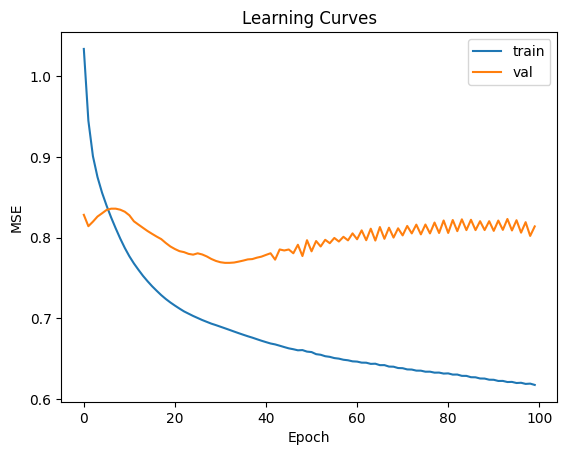

In [31]:
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from matplotlib import pyplot

seed(1)
tf.random.set_seed(2)

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()


# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1))


# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val))

# predict test set
yhat = model.predict(X_val)

# evaluate predictions
score = mean_squared_error(y_val, yhat)
print('MSE: %.3f' % score)

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Wir sehen, dass ab einer bestimmten Anzahl Epochen ein Overfitting eintritt. Da dies aber sehr stark von den tatsächlichen Eingangsdaten sowie der Initialisierung abhängt, ist es besser, keine absolute Zahl festzulegen, sondern die Technik des ["Early Stopping"](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) anzuwenden. Dabei werden nach jeder Epoche die Gewichte abgespeichert und sobald sich der Fehler im Validierungsdatensatz für eine bestimmte Anzahl von Epochen nicht mehr verbessert, bricht das Training ab (Early Stopping) und springt zu den gespeicherten Gewichten des "besten" Durchlaufs zurück.

Im Folgenden der Code von oben mit Early Stopping. Falls man Early Stopping gleich zu Beginn einbaut, empfiehlt es sich, die Anzahl der Epochen etwas höher zu setzen, damit das Early Stopping auch greifen kann. Zudem sollte man die sog. "Patience", d.h. die Anzahl der Epochen, bei der der MSE im Validation Set wieder zunehmen darf, bevor das Training gestopppt wird, nicht zu klein wählen, vor allem bei Modellen, die etwas instabil sind. Da das obige Modell recht stabil ist (keine großen Sprünge im MSE von Epoche zu Epoche), reicht hier eine Patience von 5 aus. Details zu Early Stopping (und anderen sog. "CallBacks" findet sich in der Hilfe zu [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6946 - val_loss: 2.7858
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3013 - val_loss: 2.2783
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1133 - val_loss: 1.9318
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0060 - val_loss: 1.6772
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9383 - val_loss: 1.4918
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8929 - val_loss: 1.3337
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8604 - val_loss: 1.2042
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8361 - val_loss: 1.1025
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8182 - val_loss: 1.0208
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8045 - val_loss: 0.9568
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7933 - val_loss: 0.9062
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7

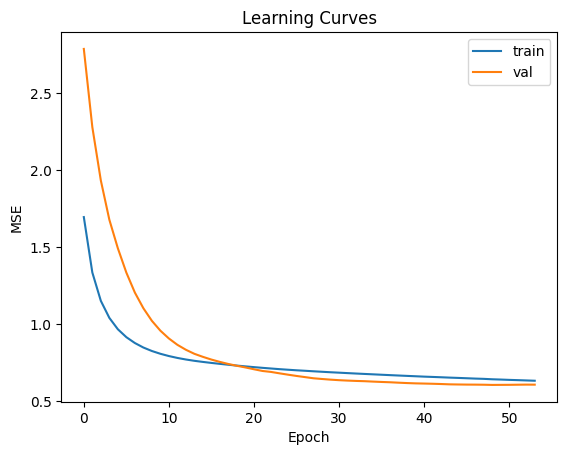

In [32]:
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot

seed(1)
tf.random.set_seed(2)

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val),
                    callbacks=[es])

# predict test set
yhat = model.predict(X_val)

# evaluate predictions
score = mean_squared_error(y_val, yhat)
print('MSE: %.3f' % score)

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### Kfold Crossvalidation
Um nun zu testen, wie robust die Vorhersage ist, wiederholen wir das Ganze mit einer [Kfold crossvalidation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold). Diese kenn wir schon vom vorigen Termin. Sie wird vom Paket sklearn zur Verfügung gestellt und kann mit beliebigen ML-Algorithmen kombiniert werden.

Wir verwenden 5 Folds, d.h. wir splitten unsere Daten in jeweils 80% Trainings- und 20% Validierungsdaten. Dafür müssen wir die Reihenfolge des Datensplitting und der Skalierung ggü. oben etwas umstellen. Das Training und die Validation werden anschließend in einer Schleife ausgeführt.

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9961 - val_loss: 1.0516
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8886 - val_loss: 0.9725
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8292 - val_loss: 0.9183
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7835 - val_loss: 0.8857
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7492 - val_loss: 0.8665
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7257 - val_loss: 0.8536
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7109 - val_loss: 0.8431
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7010 - val_loss: 0.8301
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6931 - val_loss: 0.8187
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6864 - val_loss: 0.8096
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6806 - val_loss: 0.8010
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6

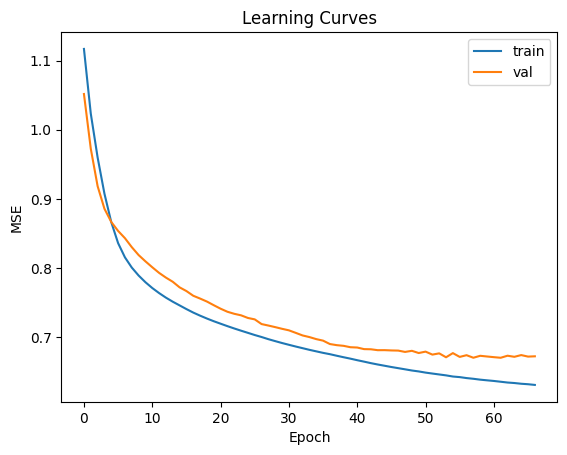

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2514 - val_loss: 4.6406
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8501 - val_loss: 3.7040
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5794 - val_loss: 3.0497
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3883 - val_loss: 2.5239
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2613 - val_loss: 2.1875
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1765 - val_loss: 1.9488
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1142 - val_loss: 1.7728
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0671 - val_loss: 1.6426
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0294 - val_loss: 1.5457
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9994 - val_loss: 1.4708
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9754 - val_loss: 1.4135
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9

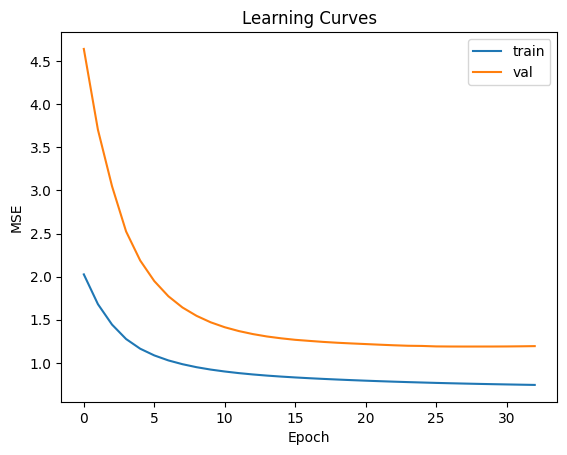

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8594 - val_loss: 1.6344
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4424 - val_loss: 1.4136
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2049 - val_loss: 1.2802
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0488 - val_loss: 1.1871
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9479 - val_loss: 1.1205
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8804 - val_loss: 1.0715
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8348 - val_loss: 1.0364
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8034 - val_loss: 1.0104
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7810 - val_loss: 0.9899
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7641 - val_loss: 0.9735
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7516 - val_loss: 0.9611
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7

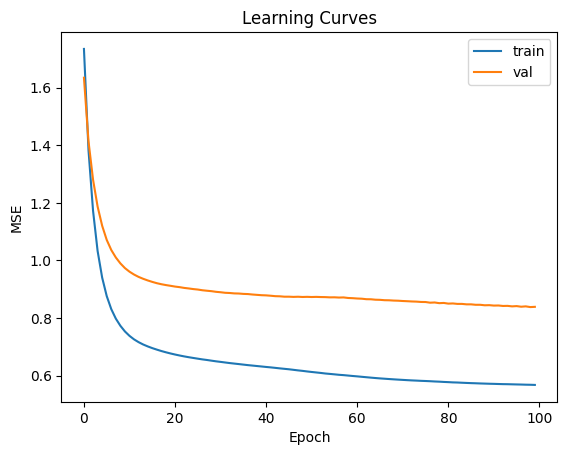

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5017 - val_loss: 1.4428
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0520 - val_loss: 1.3208
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7199 - val_loss: 1.2456
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4670 - val_loss: 1.1924
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2782 - val_loss: 1.1506
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1443 - val_loss: 1.1161
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0463 - val_loss: 1.0871
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9749 - val_loss: 1.0596
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9145 - val_loss: 1.0301
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8640 - val_loss: 1.0059
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8304 - val_loss: 0.9855
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

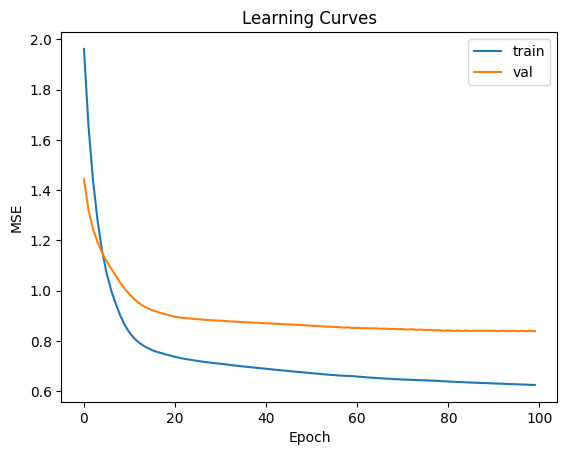

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6307 - val_loss: 1.1646
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3717 - val_loss: 1.0267
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2266 - val_loss: 0.9444
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1298 - val_loss: 0.8906
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0638 - val_loss: 0.8520
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0136 - val_loss: 0.8216
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9735 - val_loss: 0.7939
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9390 - val_loss: 0.7673
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9084 - val_loss: 0.7421
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8826 - val_loss: 0.7203
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8601 - val_loss: 0.7007
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

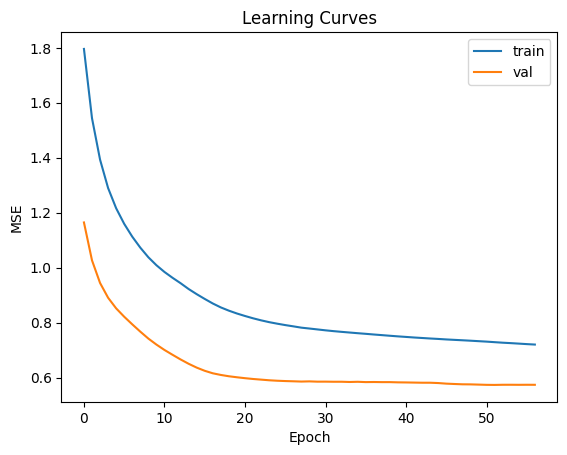

Mean MSE: 0.822 (0.210)


In [33]:
seed(1)
tf.random.set_seed(2)

temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
scaler.fit(temp)

temp = scaler.transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]

X_test, y_test = test[:, :-1], test[:, -1]


# prepare cross validation
from numpy import mean
from numpy import std

kfold = KFold(5, shuffle=True, random_state=27)

# enumerate splits
scores = list()


for train_ix, val_ix in kfold.split(X, y):
    # split data
    X_train, X_val, y_train, y_val = X[train_ix], X[val_ix], y[train_ix], y[val_ix]
    # determine the number of input features
    n_features = X.shape[1]
    # set initializer
    kernel_initializer = initializers.glorot_uniform
    
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    # define model
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val),
                       callbacks=[es])

    # predict test set
    yhat = model.predict(X_val)
    score = mean_squared_error(y_val, yhat)
    print('MSE: %.3f' % score)
    scores.append(score)
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('MSE')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()


# summarize all scores
print('Mean MSE: %.3f (%.3f)' % (mean(scores), std(scores)))

Wir sehen, dass sich sowohl der Verlauf der Lernkurven als auch die Performance (also der MSE) der einzelnen Durchläufe zum Teil stark unterscheiden kann, was zum Einen von den unterschiedlichen Initialisierungen und zum Anderem von der Aufteilung des Datensatzes abhängt.

Auch bei einer zufälligen Aufteilung kann es sein, dass "zufällig" mehr schwierig vorherzusagende Werte im Validierungsatz landen. Dies sind vor allem Werte, die in der Verteilung der Trainingsdaten seltener vorkommen. Im Beispiel von Nitrat wären das hohe Messwerte. Daher ist es wichtig, mit einer Kfold-Crossvalidation die mittlere Performance zu betrachten.

Dem Problem der Initialisierung begegnet man in der Regel damit, dass man viele Modelle mit unterschiedlichen Initialisierungen rechnet (also ein Ensemble bildet) und dann jeweils die mittlere Vorhersage aller Modelle betrachtet. Dies realisiert man über eine Schleife mit verschiedenen Seeds (in der Regel mindestens 5, meistens 10, je mehr desto robuster das Ergebnis), um die Reproduzierbarkeit zu erhalten. Wir verzichten hier darauf, da für die Übung die Rechenzeit zu lange wäre.

### Optimierung von Hyperparametern (der "einfache" Weg)

Ein einfacher Weg, Hyperparameter wie die Batchsize, Lernregel usw. zu optimieren, ist es, einfach alle möglichen Kombinationen durchzuprobieren. Dies wird als "grid search" bezeichnet. Der Vorteil ist, dass man auf jeden Fall die beste Variante finden wird, der Nachteil ist, dass bei einer größeren Anzahl von zu optimierenden Hyperparametern und deren jeweils mögliche Werte(-bereiche) die Anzahl der möglichen Kombinationen schnell so groß wird, dass eine grid search zeitlich gar nicht mehr möglich ist. Es gibt aber noch weitere, effizientere Methoden, dazu in einer späteren Vorlesung mehr.

Im Folgenden führen wir eine kleine grid search durch, wobei wir zwei weitere Optimizer und drei verschiedene Batch-Sizes testen (also 9 mögliche Kombinationen).

Wir verwenden hierzu die Funktion [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) aus dem sklearn-Paket, die genau wie Kfold mit allen möglichen ML-Algorithmen kombiniert werden kann und zusätzlich noch den KerasRegressor aus dem [scikeras-Paket](https://adriangb.com/scikeras/stable/) als Wrapper (geht auch ohne, aber so ist es einfacher).

Zunächst wird dabei ein sog. baseline_model definiert, bei dem dann bei der Optimierung basierend auf einem parameter dictionary ("param_grid") die dort definierten Parameter ausgetauscht werden.

**Die Epochenzahl wurde aus Zeitgründen in diesem Beispiel auf 30 reduziert!**


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasRegressor

# Set seeds
np.random.seed(1)
tf.random.set_seed(2)


# Split and scale
temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
temp = scaler.fit_transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]
n_features = X.shape[1]
kernel_initializer = 'he_normal'

# Model builder
def baseline_model(optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# KerasRegressor with new SciKeras API
estimator = KerasRegressor(
    model=baseline_model,
    model__optimizer='adam',  # default, will be overridden in grid
    epochs=30,
    verbose=2
)

# Grid parameters — note the `model__` prefix
param_grid = {
    "batch_size": [8, 16, 32],
    "model__optimizer": ['rmsprop', 'adam', 'SGD']
}

# Grid search
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, y)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, std, param in zip(grid_result.cv_results_['mean_test_score'],
                            grid_result.cv_results_['std_test_score'],
                            grid_result.cv_results_['params']):
    print("%f (%f) with: %r" % (mean, std, param))

Epoch 1/30
151/151 - 0s - 2ms/step - loss: 2.3705
Epoch 2/30
151/151 - 0s - 742us/step - loss: 1.5953
Epoch 3/30
151/151 - 0s - 753us/step - loss: 1.2969
Epoch 4/30
151/151 - 0s - 748us/step - loss: 1.1554
Epoch 5/30
151/151 - 0s - 730us/step - loss: 1.0645
Epoch 6/30
151/151 - 0s - 726us/step - loss: 0.9944
Epoch 7/30
151/151 - 0s - 736us/step - loss: 0.9386
Epoch 8/30
151/151 - 0s - 727us/step - loss: 0.8916
Epoch 9/30
151/151 - 0s - 738us/step - loss: 0.8523
Epoch 10/30
151/151 - 0s - 737us/step - loss: 0.8202
Epoch 11/30
151/151 - 0s - 721us/step - loss: 0.7948
Epoch 12/30
151/151 - 0s - 730us/step - loss: 0.7743
Epoch 13/30
151/151 - 0s - 747us/step - loss: 0.7569
Epoch 14/30
151/151 - 0s - 737us/step - loss: 0.7433
Epoch 15/30
151/151 - 0s - 729us/step - loss: 0.7320
Epoch 16/30
151/151 - 0s - 733us/step - loss: 0.7221
Epoch 17/30
151/151 - 0s - 742us/step - loss: 0.7142
Epoch 18/30
151/151 - 0s - 742us/step - loss: 0.7080
Epoch 19/30
151/151 - 0s - 727us/step - loss: 0.7028
Epoc

**Achtung:** Auch hier kann die beste Hyperparameter-Kombination von Durchlauf zu Durchlauf variieren, was wiederum an der Aufteilung der Daten und unterschiedlichen Initialisierungen liegt. Man müsste jeweils wiederum ein Ensemble mehrerer Seeds einbauen, um zu belastbaren Ergebnisse zu kommmen. Aber das dauert für die Übung zu lange...

### Vorhersage der Test-Daten mit dem besten Modell

Jetzt wo wir wissen, was die beste Hyperparameter-Kombination ist, bauen wir das Modell nochmals neu auf, trainieren es mit dem kompletten Trainingsdatensatz (inklusive der Valididierungs-Daten) und sagen damit die Nitrat-Werte unseres Test-Datensatzes voraus. Ggf. weicht die "beste" Hyperparameter-Kombination von der hier gewählten ab. Dies hängt mir der Zufallskomponente bei der Initialisierung zusammen. Streng genommen muss daher auch bei der Optimierung immer mit Ensemblen von verschiedenen Initialisierungen (i.d.R. mindestens 10) gerechnet und eine mittlere Performance der jeweiligen HP-Kombination ermittelt werden. In der Praxis ist jedoch der Rechenaufwand dafür meist zu hoch. D.h. man gibt sich mit einem "guten", wenn auch nicht unbedingt dem "besten" Modell zufrieden.

Weiterhin nehmen wir die Skalierung getrennt nach Input- und Target-Daten vor, was später eine inverse Transformation erleichtert.

In [35]:
seed(1)
tf.random.set_seed(2)

# Split data
train, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

# Input- and Target-Data
X_train = train.values[:, :-1] # for all but last column --> Input variables
y_train = train.values[:, -1] # for last column --> Target variable

X_test = test.values[:, :-1] # for all but last column --> Input variables
y_test = test.values[:, -1] # for last column --> Target variable

# reshape 1d arrays to 2d arrays

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

# Scale data
scaler_input, scaler_target = StandardScaler(), StandardScaler()
scaler_input.fit(X_train)
scaler_target.fit(y_train)

X_train = scaler_input.transform(X_train)
y_train = scaler_target.transform(y_train)

X_test = scaler_input.transform(X_test)
y_test = scaler_target.transform(y_test)


# determine the number of input features
n_features = X_train.shape[1]

# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1))

# compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# fit/train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=1)

# predict Test data
yhat = model.predict(X_test)

# Scores
score = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % score)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 2.6060
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 1.6942
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 1.3766
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 1.2150
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 1.1076
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 1.0261
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 0.9685
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.9268
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.8904
Epoch 10/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 0.8607
Epoch 11/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.8353
Epoch 12/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.8135
Epoch 13/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.7966
Epoch 14/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.7827
Epoch 15/30
188/188 ━━━━━━━━━

### Vergleich vorhergesagte und tatsächliche Daten im Test Set

Um die vorhergesagten und tatsächlichen Daten zu vergleichen, können wir nun weitere Fehlermaße berechnen (z.B. MSE, RMSE, R²) sowie die Daten in einem Scatterplot darstellen. Dazu re-transformieren wir die Zieldaten zunächst wieder auf die ursprünglichen Werte.


MSE: 466.177
RMSE: 21.591
R_squared: 0.244


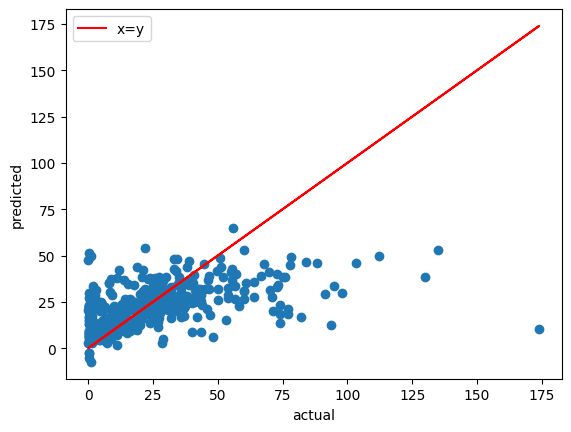

In [36]:
import matplotlib.pyplot as plt

# inverse transform
y_test = scaler_target.inverse_transform(y_test)
yhat = scaler_target.inverse_transform(yhat)

# Scores
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % np.sqrt(mse))
print('R_squared: %.3f' % r2)

plt.figure()
plt.scatter(y_test, yhat)
plt.plot(y_test, y_test, color = 'red', label = 'x=y')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend()
plt.show()

Naja, nicht ganz perfekt :-) Vor allem die höheren Werte scheinen schwieriger vorherzusagen zu sein. Das liegt daran, dass diese auch im Trainingsdatensatz seltener vorkommen (ein bekanntes Problem, was als "imbalanced regression/classification" bezeichnet wird). Außerdem werden offensichtlich Werte kleiner Null vorhergesagt, was für eine Konzentration ja nicht sinnvoll ist. Auch hier gibt es jedoch Techniken, dies zu vermeiden, indem man z.B. ReLu auch als Aktivierungsfunktion für das Output-Neuron verwendet.

Eine weitere Optimierung könnte man durch folgende Punkte erreichen:

* Die Aquiferkennzahl ist eigentlich eine kategorische Variable, wurde bisher aber ordinal encodiert. Hier könnte man ein One-Hot- oder Target-Encoding testen.
* Vermutlich korrelieren einige der Input-Variablen recht stark miteinander. Durch eine vorgeschaltete PCA könnten sich die Vorhersagen ebenfalls verbessern.
* Die Hyperparameter könnten noch besser optimiert werden, d.h. mehr Optionen für die bereits getesteten Hyperparameter oder weitere wie die Aktivierungsfunktion, Initialisierung und Lernrate.
* Man könnte die Anzahl der Neuronen und die Anzahl der Schichten verändern.

## Übungsaufgabe 1

Verändern Sie die Anzahl der Neuronen in der verdeckten Schicht! Sie können dies ebenfalls mit einer GridSearchCV machen, in dem Sie einen Parameter "neurons" im dictionary param_grid (s.o.) definieren und für diesen verschiedene Anzahlen als Optionen vorgeben. Damit die GridSearch nicht zu lange dauert, sollten sie die anderen Optimierungsparameter dafür rausnehmen, d.h. mit der besten HP-Kombination von oben arbeiten und nur noch die Anzahl der Neuronen optimieren. Experimentieren Sie außerdem noch mit einer zweiten verdeckten Schicht und optimieren Sie in dieser ebenfalls die Anzahl der Neuronen.
**Achtung:** Bei der Definition des baseline_model müssen sie für Parameter, die später über das param_dict definiert werden, einen Anfangswert eingeben!

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasRegressor

# Set seeds
np.random.seed(1)
tf.random.set_seed(2)


# Split and scale
temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
temp = scaler.fit_transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]
n_features = X.shape[1]
kernel_initializer = 'he_normal'

# Model builder
def baseline_model(optimizer='adam', neurons='5'):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(neurons, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# KerasRegressor with new SciKeras API
estimator = KerasRegressor(
    model=baseline_model,
    model__optimizer='adam',  # default, will be overridden in grid
    epochs=30,
    verbose=2
)

# ...

## Übungsaufgabe 2

Da sich mit einer veränderten Zahl der Neuronen und/oder Schichten wiederum andere Hyperparameter, vor allem die Anzahl der Epochen und der Batch-Size als günstiger erweisen könnten, ist es am besten, möglichst viele Hyperparameter gleichzeitig zu optimieren. Hier stößt die GridSearchCV aber schnell an ihre Grenzen. Eine weitere Alternative ist die [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), bei der eine definierte Anzahl an zufällig gewählten Kombination aus dem vorgegebenen Parameter-Space getestet werden. Hierbei ist zwar nicht garantiert, dass die absolut beste Kombination gefunden wird, jedoch liefert es meistens bei einem geringeren Rechenaufwand schon ganz brauchbare Hinweise, welche Kombinationen gut funktionieren und welche nicht.

**Achtung:** beim Befehl RandomizedSearchCV wird der Parameter "param_grid" durch "param_distributions" ersetzt. Ansonsten ist die Verwendung exakt gleich wie bei GridSearchCV. Als weitere Option kann man die Anzahl der Iterationen über "n_iter" festelegen. Default-Wert ist 10. Weiter Informationen finden sich auch in der Hilfe: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Optimieren Sie nun mehrere Hyperparameter gleichzeitig! Für den optimizer können Sie z.B. zusätzlich die Optionen 'Adagrad', 'Adadelta', 'Adamax' und 'Nadam' testen. Für die Aktivierungsfunktion kommen z.B. 'softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear' in Frage und für die Initialisierung 'uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'. Je mehr Parameter und Optionen Sie gleichzeitig verwenden, desto höher sollten Sie den Wert für n_iter setzen, damit eine vernünftige Anzahl der möglichen Kombinationen ausprobiert wird. Als Daumenwert sollte dies mindestens etwa 0,1 * die Anzahl aller möglichen Kombinationen sein!

In [ ]:
import scikeras
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def baseline_model(optimizer='adam', neurons=5, activation='relu'):
   
    # define model
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data
# ...


grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring='neg_mean_squared_error', n_iter=50)

# ...

Wenn Sie eine bessere Parameterkombination als in der Vorlesung verwendet finden, so schreiben Sie den Algorithmus zur Vorhersage der Test-Daten mit dem besten Modell entsprechend um und sagen Sie dann mit diesem wiederum die Test-Daten voraus. Wie haben sich hier die Ergebnisse verändert?

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 3

Wenden Sie die gelernten Methoden des Kfold Crossvalidation und der Hyperparameter-Optimierung auch auf die Binär-Klassifikation an und schauen Sie, ob Sie die Performance des Random Forest aus Termin 3 übertreffen können.

In [ ]:
# ...

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 4

Wenden Sie nun die hier gelernten Methoden zur Regression mit einem MLP auf den Beton-Datensatz aus Termin 3 (Concrete_Data.csv) an! Wie sind die Ergebnisse, die Sie erzielen können im Vergleich zum in Termin 3 angewandten Random-Forest Methode?

In [ ]:
# ...

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 5 (optional, daher keine Lösung)

Testen Sie, ob Sie für den Grundwasserqualitätsdatensatz die Vorhersage von Nitrat verbessern können, wenn Sie eine PCA vorschalten und/oder den Aquifer anders codieren!